# Introduction to Bayesian Analysis via Grid Methods

by Henry Bechtel 

Many introductions to Bayesian analysis can either be too simplistic or too complex. I think grid methods offer great insight into how Bayesian analysis works that can go beyond simple, toy examples and can also show why MCMC methods are required for more complex problems.

Special thanks to excellent, inspirational work by Allen Downey and Brandon Rohrer.

In [1]:
import numpy as np
import scipy.stats as stats
import matplotlib.pyplot as plt

## Biased Coins
Let's say we have some obervations of coin flips.

In [2]:
observations = np.array([1,0,1,1,1,0])
positive_obs = sum(observations)
total_obs = len(observations)

In [3]:
number_of_hypotheses = 100
hypotheses = np.linspace(0,1, number_of_hypotheses)

You know what... let's do something more interesting.

## Measurement Errors

Let's look at a more complex example. Here we are going to simulate a guassian process with some known parameters that we will try to recover.

Let's say we only saw 5 observations.

In [4]:
mean_true=15
sd_true=2

observations = np.random.normal(mean_true, sd_true, 5)
observations

array([14.10103135, 13.63970061, 15.92305877, 13.15407935, 14.6056184 ])

First let's take a standard approach and take the mean and standard deviation or our observed samples. We could stop here and generate a normal distribution that quantified our beleif in what the true paramters are.

In [5]:
np.mean(observations), np.std(observations)

(14.284697695483402, 0.9502914809494667)

But let's get our Bayes on and incorporate a prior. We'll keep it flat for now, but this will still give us a better idea about how our hypotheses are likely to be distributed.

Setting up our "grid" for two parameters we are trying to infer

In [6]:
hypotheses_1 = np.linspace(12,18,100) #These are all the means we want to test
hypotheses_2 = np.linspace(0.001,4,100) #These are all the standard deviations we want to test

In [7]:
prior = np.ones([len(hypotheses_1),len(hypotheses_2)]) # Here we are choosing a flat prior

In [8]:
unnormalized_posterior = np.zeros([len(hypotheses_1),len(hypotheses_2)])

In [9]:
marginal_likelihood = 0
for i in range(len(hypotheses_1)):
    mean = hypotheses_1[i]
    for j in range(len(hypotheses_2)):
        sd = hypotheses_2[j]
        unnormalized_likelihood = 1
        for x in observations:
            unnormalized_likelihood *= stats.distributions.norm.pdf(x,mean,sd)
        unnormalized_posterior[i,j] = unnormalized_likelihood*prior[i,j]        
        marginal_likelihood += unnormalized_likelihood*prior[i,j] 
        
posterior = unnormalized_posterior/marginal_likelihood

Let's check that our posterior integrates to 1.

In [10]:
sum(sum(posterior))

1.0000000000000007

Let's find where the maximum probabilities are located in our grid.

In [11]:
max_posterior = np.where(posterior == np.amax(posterior))
max_posterior

(array([38]), array([24]))

Let's check the point estimates of our grid method and compare with the standard calculations.

In [12]:
print(f'Mean of obervations:{np.mean(observations)}, Mean with Bayes:{hypotheses_1[max_posterior[0]]}' )
print(f'Std Dev of obervations:{np.std(observations)}, Std Dev estimated with Bayes:{hypotheses_2[max_posterior[1]]}')

Mean of obervations:14.284697695483402, Mean with Bayes:[14.3030303]
Std Dev of obervations:0.9502914809494667, Std Dev estimated with Bayes:[0.97045455]


Nice. Pretty similar... So why did we go through all that trouble to just get the same point estimates? Well, that's not all we get! We also get a posterior distribution for each of our parameters of interest.

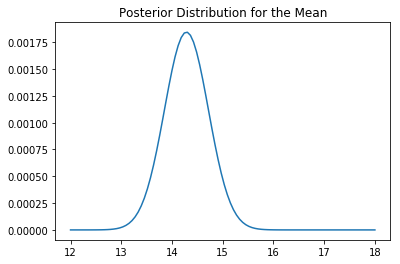

In [13]:
plt.plot(hypotheses_1, posterior[:,max_posterior[1]]);
plt.title("Posterior Distribution for the Mean");

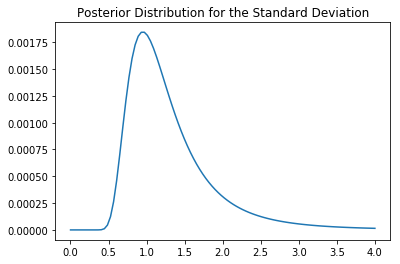

In [14]:
plt.plot(hypotheses_2, posterior[max_posterior[0],:].T);
plt.title("Posterior Distribution for the Standard Deviation");

Sweet. Now let's look at what our 2D prior and posterior distribution looks like with a contour plot.

Text(0, 0.5, 'Probabilty')

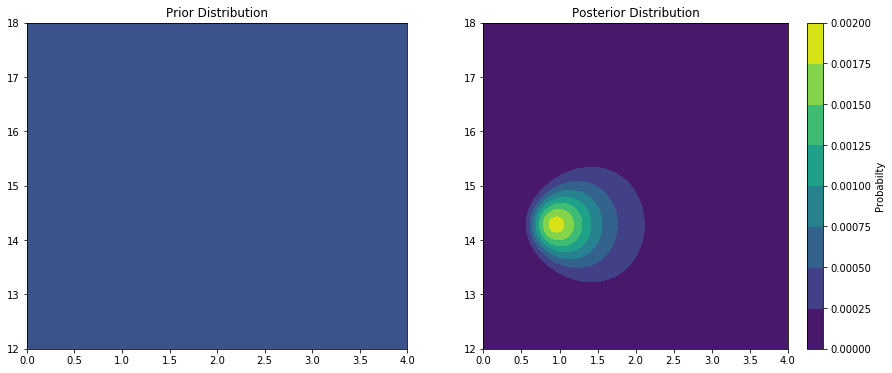

In [15]:
fig, ax = plt.subplots(1,2, figsize=(15,6))
X, Y = np.meshgrid(hypotheses_2, hypotheses_1)
ax[0].set_title('Prior Distribution')
ax[0].contourf(X,Y, prior);
ax[1].set_title('Posterior Distribution')
CS = ax[1].contourf(X,Y, posterior);
cbar = fig.colorbar(CS)
cbar.ax.set_ylabel('Probabilty')

# Linear Regression

Ok, let's step it up another notch and see if we can perform linear regression using only Bayes Rule, a normal pdf, and for-loops. Again, we're going to generate simulated data so we can know how we are doing with our Bayesian inference.

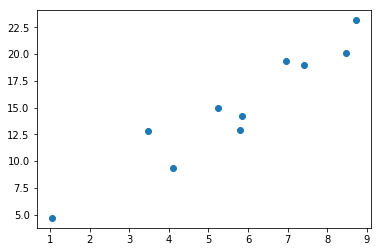

In [32]:
b0_true = 4
b1_true = 2
sigma_true = 2

x = np.random.normal(6,2,10)
y = b0_true + b1_true*x + np.random.randn(len(x))*sigma_true

plt.scatter(x,y);

Now we have three parameters that we will have a range of hypotheses for: Slope, intercept, and sigma.

Setting up our grid of hypotheses:

In [33]:
hypotheses_b0 = np.linspace(2,6,40) #These are all the intercepts we want to test
hypotheses_b1 = np.linspace(1,4,40) #These are all the slopes we want to test
hypotheses_s = np.linspace(0.001,4,40) #These are all the standard deviations we want to test

In [34]:
prior = np.ones([len(hypotheses_b0), len(hypotheses_b1),len(hypotheses_s)]) # Flat prior

In [35]:
unnormalized_posterior = np.zeros([len(hypotheses_b0), len(hypotheses_b1),len(hypotheses_s)])

Now to loop through all combinations of parameters

In [36]:
marginal_likelihood = 0
for i in range(len(hypotheses_b0)):
    b0 = hypotheses_b0[i]
    for j in range(len(hypotheses_b1)):
        b1 = hypotheses_b1[j]
        for k in range(len(hypotheses_s)):
            s = hypotheses_s[k]
            unnormalized_likelihood = 1 
            for d in range(len(x)):
                unnormalized_likelihood *= stats.distributions.norm.pdf(y[d],loc=b0+b1*x[d],scale=s)
            unnormalized_posterior[i, j, k] = unnormalized_likelihood*prior[i, j, k]
            marginal_likelihood += unnormalized_likelihood*prior[i, j, k]   
                
posterior = unnormalized_posterior/marginal_likelihood

In [37]:
sum(sum(sum(posterior)))

1.000000000000027

In [38]:
max_posterior = np.where(posterior == np.amax(posterior))
max_posterior

(array([3]), array([16]), array([15]))

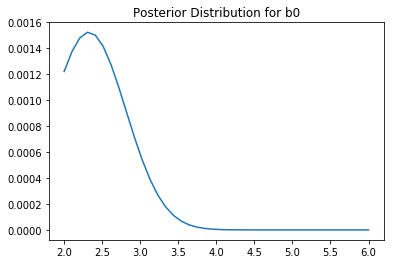

In [39]:
plt.plot(hypotheses_b0, posterior[:,max_posterior[1],max_posterior[2]]);
plt.title("Posterior Distribution for b0");

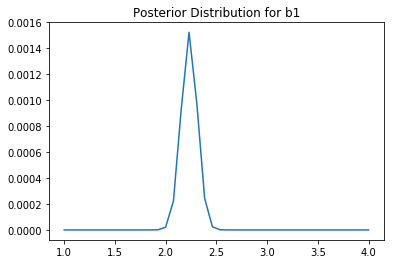

In [40]:
plt.plot(hypotheses_b1, posterior[max_posterior[0],:,max_posterior[2]].T);
plt.title("Posterior Distribution for b1");

In [41]:
print(f'b0 with Bayes:{hypotheses_b0[max_posterior[0]]}') 
print(f'b1 with Bayes:{hypotheses_b1[max_posterior[1]]}') 
print(f'sigma with Bayes:{hypotheses_s[max_posterior[2]]}') 

b0 with Bayes:[2.30769231]
b1 with Bayes:[2.23076923]
sigma with Bayes:[1.53907692]


Checking what sklearn returns for slope and intercept for comparison.

In [42]:
from sklearn.linear_model import LinearRegression

In [43]:
lr = LinearRegression()
lr.fit(x.reshape(-1,1), y.reshape(-1,1))

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [44]:
lr.intercept_, lr.coef_

(array([2.35118567]), array([[2.22603915]]))

And let's check out some more statistical details using statsmodels

In [45]:
import statsmodels.api as sm

In [46]:
x1 = sm.add_constant(x)
sm.OLS(y, x1).fit().summary()

/Users/Henry/anaconda3/lib/python3.7/site-packages/scipy/stats/stats.py:1416: UserWarning: kurtosistest only valid for n>=20 ... continuing anyway, n=10
  "anyway, n=%i" % int(n))


<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.911
Model:                            OLS   Adj. R-squared:                  0.900
Method:                 Least Squares   F-statistic:                     81.84
Date:                Wed, 31 Jul 2019   Prob (F-statistic):           1.78e-05
Time:                        21:58:44   Log-Likelihood:                -18.667
No. Observations:                  10   AIC:                             41.33
Df Residuals:                       8   BIC:                             41.94
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.3512      1.510      1.557      0.158      -1.130       5.832
x1             2.2260      0.246      9.046      0.000       1.659       2.793
==============================================================================
Omnibus:                        0.479   Durbin-Watson:                   1.326
Prob(Omnibus):                  0.787   Jarque-Bera (JB):                0.489
Skew:                           0.058   Prob(JB):                        0.783
Kurtosis:                       1.922   Cond. No.                         17.1
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""